In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the zip file containing your dataset and metadata

In [ ]:
!unzip "/content/drive/My Drive/548681_1157383_bundle_archive.zip"

Importing the Libraries

In [9]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import imutils
from imutils import paths
import random

In [10]:
%%bash
rm -rf dataset/train/covid/
rm -rf dataset/train/normal/
rm -rf dataset/test/covid
rm -rf dataset/test/normal
rm -rf dataset
mkdir -p dataset/train/covid
mkdir -p dataset/train/normal
mkdir -p dataset/test/covid
mkdir -p dataset/test/normal

In [11]:
dataset_path = './dataset'

In [12]:
covid_dataset_path = './images' 

In [13]:
df = pd.read_csv('metadata.csv')
print(df['finding'].value_counts())
print(df['view'].value_counts())
print(df.columns)

COVID-19          296
Streptococcus      17
SARS               16
Pneumocystis       15
COVID-19, ARDS     12
E.Coli              4
ARDS                4
No Finding          3
Legionella          2
Chlamydophila       2
Klebsiella          1
Name: finding, dtype: int64
PA               195
AP                58
AP Supine         45
Axial             41
L                 29
Coronal            3
AP semi erect      1
Name: view, dtype: int64
Index(['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'folder', 'filename', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes', 'Unnamed: 28'],
      dtype='object')


In [ ]:
# loop over the rows of the COVID-19 data frame to set the training data
count = 0
for (i, row) in df.iterrows():
    # As the dataset is imbalanced sample the data to prevent over fitting.
    #if count > 70:
    #  break
    if row["finding"] == "COVID-19" and row['view'] == 'PA':
        # build the path to the input image file
        imagePath = os.path.sep.join([f"{covid_dataset_path}", row["filename"]])
        print(imagePath)

        if not os.path.exists(imagePath):
            continue
        outputPath = os.path.sep.join([f"{dataset_path}/train/covid", row["filename"]])
        print(outputPath)
        # copy the image
        shutil.copy2(imagePath, outputPath)
     #   count+=1

In [ ]:
# loop over the rows of the Normal data frame for setting the training dataset

for (i, row) in df.iterrows():

    if row["finding"] != "COVID-19" and row['view'] == 'PA':
        # build the path to the input image file
        imagePath = os.path.sep.join([f"{covid_dataset_path}", row["filename"]])
        print(imagePath)

        if not os.path.exists(imagePath):
            continue
        outputPath = os.path.sep.join([f"{dataset_path}/train/normal", row["filename"]])
        print(outputPath)
        # copy the image
        shutil.copy2(imagePath, outputPath)


Moving a part of the training dataset to the validation dataset

In [ ]:
basePath = './dataset/train/normal'
imagePaths = list(paths.list_images(basePath))
samples = 15
# randomly sample the image paths
random.seed(50)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    print(imagePath)
    if os.path.exists(imagePath):
      filename = imagePath.split(os.path.sep)[-1]
      outputPath = os.path.sep.join([f"{dataset_path}/test/normal", filename])

      # cut the image
      shutil.move(imagePath, outputPath)

In [ ]:
basePath = './dataset/train/covid'
imagePaths = list(paths.list_images(basePath))
samples = 15
# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    print(imagePath)
    if os.path.exists(imagePath):
      filename = imagePath.split(os.path.sep)[-1]
      outputPath = os.path.sep.join([f"{dataset_path}/test/covid", filename])

      # cut the image
      shutil.move(imagePath, outputPath)

View the images

In [18]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

126 15
39 15


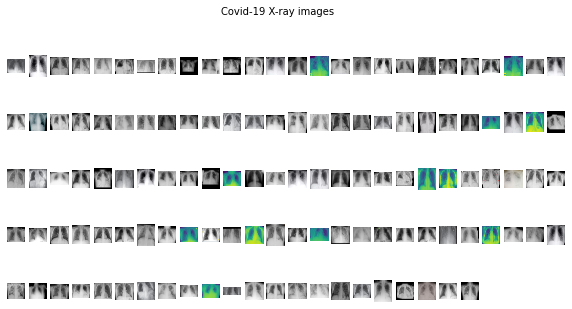

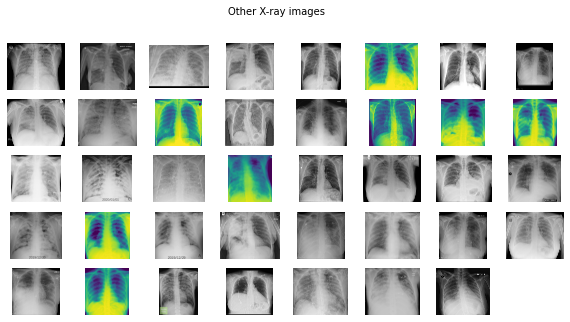

In [19]:
from imutils import paths
covid_images = list(paths.list_images(f"{dataset_path}/train/covid"))
normal_images = list(paths.list_images(f"{dataset_path}/train/normal"))
covid_test_images = list(paths.list_images(f"{dataset_path}/test/covid"))
normal_test_images = list(paths.list_images(f"{dataset_path}/test/normal"))
print(len(covid_images), len(covid_test_images))
print(len(normal_images), len(normal_test_images))
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")
plots_from_files(normal_images, rows=5, maintitle="Other X-ray images")

Importing the libraries

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Preprocessing the tarining directory and Validation directory

In [21]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        './dataset/train',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        './dataset/test',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 165 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


Building the Inception Model

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-18 04:30:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  69.1MB/s    in 1.2s    

2020-09-18 04:30:35 (69.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [36]:
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = InceptionV3(weights=None, input_shape = (224, 224, 3), include_top=False)
base_model.load_weights(weights)

for layer in base_model.layers:
    layer.trainable = False

last_layer = base_model.get_layer('mixed5')
last_output = last_layer.output

end_model = layers.Flatten()(last_output)
end_model = layers.Dropout(0.2)(end_model)
end_model = layers.Dense(units=512, activation='relu')(end_model)
end_model = layers.Dropout(0.2)(end_model)
end_model = layers.Dense(units=1, activation='sigmoid')(end_model)
Inceptionmodel = Model(inputs=base_model.input, outputs=end_model)
Inceptionmodel.summary()



Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 111, 111, 32) 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 111, 111, 32) 0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

In [22]:
class MyCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_acc') >= 0.90 :
      print("\n Reahed accuracy above 70% ")
      self.model.stop_training = True

Fitting your Model

In [46]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0003, decay=0.0003/10)
Inceptionmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
hist_model = Inceptionmodel.fit(x=train_generator, validation_data=validation_generator, epochs=15, callbacks=[MyCallback()])

Epoch 1/15
9/9 [==============================] - 8s 869ms/step - loss: 0.0875 - acc: 0.9515 - val_loss: 0.8284 - val_acc: 0.8000
Epoch 2/15
9/9 [==============================] - 7s 737ms/step - loss: 0.0902 - acc: 0.9697 - val_loss: 0.7760 - val_acc: 0.8000
Epoch 3/15
9/9 [==============================] - 7s 731ms/step - loss: 0.0529 - acc: 0.9818 - val_loss: 1.2535 - val_acc: 0.6000
Epoch 4/15
9/9 [==============================] - 7s 802ms/step - loss: 0.0646 - acc: 0.9818 - val_loss: 0.5993 - val_acc: 0.8000
Epoch 5/15
9/9 [==============================] - 7s 779ms/step - loss: 0.0615 - acc: 0.9818 - val_loss: 0.9437 - val_acc: 0.6000
Epoch 6/15
9/9 [==============================] - 6s 714ms/step - loss: 0.0583 - acc: 0.9818 - val_loss: 1.1130 - val_acc: 0.6000
Epoch 7/15
9/9 [==============================] - 7s 741ms/step - loss: 0.0464 - acc: 0.9879 - val_loss: 0.6928 - val_acc: 0.7667
Epoch 8/15
9/9 [==============================] - 6s 719ms/step - loss: 0.0316 - acc: 0.99

Testing on an unseen image

In [43]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('/content/images/extubation-8.jpg', target_size=(224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = Inceptionmodel.predict(test_image)
train_generator.class_indices
if result[0][0] == 0:
  print("Covid")
else:
  print("Non-Covid")

Covid


Visualizing the Simple CNN Model's accuracy curve

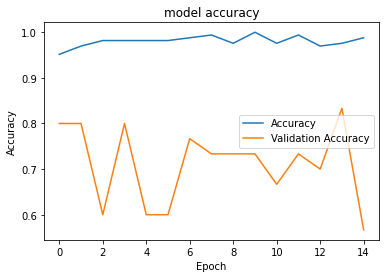

In [47]:
plt.plot(hist_model.history["acc"])
plt.plot(hist_model.history['val_acc'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

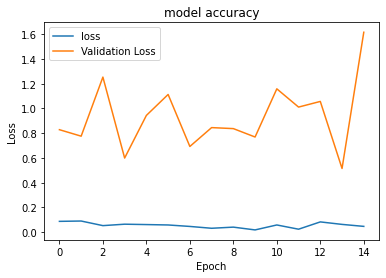

In [48]:
plt.plot(hist_model.history['loss'])
plt.plot(hist_model.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()